# Classification: Language Detection

Authors: Pierre Nugues and Marcus Klang

Reimplementation of Google's _Compact language detector_ (CLD3) from a high-level description. Read the description here: https://github.com/google/cld3

The model has three different embeddings as first layer

## Overview

Your classifier will read a short text, typically a few words or a sentence, and output the probability for all languages observed during training. The text will have a variable length and will be encoded as a Unicode string.

As dataset to train your models, you will use [Tatoeba](https://tatoeba.org/sv/), a collaborative, open, and free collection of sentences and translations. 

You will break down the task into four steps:
    
  1. Data processing, converting the data into a machine-learnable representation
  2. Try and evaluate a simple model, logistic regression. This will be your baseline.
  3. Try and evaluate a deeper model inspired by Google's compact language detector, CLD3.
  4. CLD3 includes an embedding vectorization. This last part is left as an optional exercise.

### The Model: CLD3

CLD3 has three major characteristics:

   * It uses **$n$-grams** and splits an input text like _banana_ into three feature vectors that include:
       + Each unique character, unigrams ($n=1$)
       + Each unique pair of characters obtained from a sliding window of size 2, bigrams ($n=2$)
       + Each unique triple of characters obtained from a sliding window of size 3, trigrams ($n=3$)
       + These feature sets map to a set of indices (integer value).
   
   * It **hashes each symbol** i.e. it encrypts the $n$-gram into a fixed range integer.
       + This way of mapping features to indices is called feature hashing or the *hashing trick*
       + It reduces the number of symbols.
       + Constant memory requirements, depends on the hash function -- commonly only a few constants.
       + It is an approximate method as collisions can and will occur. Adjusting the size of the feature space i.e. the number of features to hash to, the collision probability can be reduced.
   
   * For each value of $n$, 1, 2, and 3, CLD3 computes the relative frequencies of the $n$-grams and **use them as weights**. See the figure below.
       + The model can map the input indices to embedding vectors (this part is optional)
       + It then computes the **weighted average** of the embeddings (this part is optional)
       + The model learns the embeddings during training (also optional)
       
The figure below shows the final architecture.

![Model overview](https://raw.githubusercontent.com/google/cld3/master/model.png)
Image source: https://github.com/google/cld3

## Dataset: Tatoeba

Your instructors have downsampled Tatoeba to reduce training times and guarantee that all the students have the same datasets.
* Link to datasets: https://github.com/pnugues/edan96/tree/main/classification%20lab
* Link to preprocessing notebook: https://github.com/pnugues/edan96/blob/main/programs/5-tatoeba_eda_select.ipynb

You are only required to process the small dataset. The larger one may take take and be difficult to process on small computers.

## Preliminaries

In [1]:
import random
import hashlib
from collections import Counter
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix

from typing import List, Dict, Tuple

In [2]:
random.seed(4321)
torch.manual_seed(4321)

## Reading the Dataset

In [3]:
FILENAME_TRAIN = 'train.tsv'
FILENAME_VAL = 'val.tsv'
FILENAME_TEST = 'test.tsv'

In [4]:
SMALL_DATASET_PATH = 'small_dataset'
LARGE_DATASET_PATH = 'large_dataset'

## Settings
You have here the most significant settings

In [5]:
LARGE_DATASET = True # Use the small or large dataset
REL_FREQ = True # How we represent the n-grams in the input vector: with their relative frequency or with a 1 (NOT USED)

In [6]:
HIDDEN_LAYER = False  # Neural network with one hidden layer or logistic regression
EPOCHS = 10 # Number of epochs
BATCH_SIZE = 128 # How many examples we will use for an update in the gradient descent
EMBEDDING_DIM = 64
EMBEDDING_DIM_UNI = 32
EMBEDDING_DIM_BI = 64
EMBEDDING_DIM_TRI = 128

In [7]:
if LARGE_DATASET:
    dataset_path = LARGE_DATASET_PATH
else:
    dataset_path = SMALL_DATASET_PATH
    
FILE_TRAIN = dataset_path + '/' + FILENAME_TRAIN
FILE_VAL = dataset_path + '/' + FILENAME_VAL
FILE_TEST = dataset_path + '/' + FILENAME_TEST

We create a generator to read the datasets

In [8]:
def file_reader(file: str):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            yield tuple(row.split('\t'))

In [9]:
line_generator = file_reader(FILE_TRAIN)

And we count the sentences per language

In [10]:
lang_freqs = Counter(map(lambda x: x[1], line_generator))

In [11]:
lang_freqs.most_common(15)

[('rus', 12314),
 ('mkd', 12149),
 ('lfn', 12132),
 ('srp', 12127),
 ('lit', 12126),
 ('lat', 12115),
 ('bul', 12111),
 ('ukr', 12093),
 ('ell', 12084),
 ('vie', 12079),
 ('nld', 12074),
 ('hau', 12073),
 ('kab', 12066),
 ('ron', 12065),
 ('deu', 12064)]

In [12]:
langs = sorted(list(set(lang_freqs.keys())))
langs[:10]

['ara', 'ber', 'bul', 'ces', 'cmn', 'dan', 'deu', 'ell', 'eng', 'epo']

You will create an index of the languages of your dataset: Assign a number to each language. You will call it `idx2lang` and its type will be a dictionary.

In [13]:
idx2lang = {idx:lang for idx, lang in enumerate(langs)}

In [14]:
idx2lang

{0: 'ara',
 1: 'ber',
 2: 'bul',
 3: 'ces',
 4: 'cmn',
 5: 'dan',
 6: 'deu',
 7: 'ell',
 8: 'eng',
 9: 'epo',
 10: 'fin',
 11: 'fra',
 12: 'hau',
 13: 'heb',
 14: 'hun',
 15: 'ina',
 16: 'ita',
 17: 'jpn',
 18: 'kab',
 19: 'lat',
 20: 'lfn',
 21: 'lit',
 22: 'mar',
 23: 'mkd',
 24: 'nld',
 25: 'pes',
 26: 'pol',
 27: 'por',
 28: 'ron',
 29: 'rus',
 30: 'spa',
 31: 'srp',
 32: 'swc',
 33: 'swe',
 34: 'tlh',
 35: 'tok',
 36: 'tur',
 37: 'ukr',
 38: 'vie'}

Write the reverted `lang2idx` index to convert languages to indices. It is also a dictionary

In [15]:
lang2idx = {lang:idx for idx, lang in idx2lang.items()}

In [16]:
lang2idx

{'ara': 0,
 'ber': 1,
 'bul': 2,
 'ces': 3,
 'cmn': 4,
 'dan': 5,
 'deu': 6,
 'ell': 7,
 'eng': 8,
 'epo': 9,
 'fin': 10,
 'fra': 11,
 'hau': 12,
 'heb': 13,
 'hun': 14,
 'ina': 15,
 'ita': 16,
 'jpn': 17,
 'kab': 18,
 'lat': 19,
 'lfn': 20,
 'lit': 21,
 'mar': 22,
 'mkd': 23,
 'nld': 24,
 'pes': 25,
 'pol': 26,
 'por': 27,
 'ron': 28,
 'rus': 29,
 'spa': 30,
 'srp': 31,
 'swc': 32,
 'swe': 33,
 'tlh': 34,
 'tok': 35,
 'tur': 36,
 'ukr': 37,
 'vie': 38}

## Data processing — convert the sentences into feature vectors

For the context of this program, a feature is a string of 1 to 3 characters. 
In natural language processing, they are called $n$-grams as they can have a varying size and are created from a sliding window.

Common sizes of $n$ have names unigrams ($n$=1), bigrams ($n$=2), and trigrams ($n$=3))

To serve as input, we have to convert these $n$-grams to numbers. There are two common ways to encode features into indices:
 * Mapping each symbol to an index
    + Exact and precise
    + Can have high memory requirements with vast feature spaces as each known feature must be stored and be assigned a unique index.
    + Slow, you need to precompute your feature space, convert the incoming data to an index and retain the mapping in memory at all times.
 * Hashing trick: hash the feature into a index
    + Supports an arbitrary number of features with the caveat of collisions.
    + Constant memory requirements
    + Fast, any feature even an unknown one can be converted into a feature index
    + However, if the feature space is too small, features will have many collisions. You have then to choose a good hash function and a feature space that is big enough
    
We will use the [hashing trick](https://en.wikipedia.org/wiki/Feature_hashing). In Python, `hash` is a function that converts any supported object into a number (hash code) but it is not reproducible across the sessions - it changes each time the interpreter is started.
We have therefore provided a new function `reproducible_hash` that hashes a string but in a reproducible way.

The number returned by `reproducible_hash` is big and needs to be converted into a limited space. This can be done with the use of the remainder of an integer division, the [modulo](https://en.wikipedia.org/wiki/Modulo_operation).

### Extracting $n$-grams

Create an $n$-gram function that returns the $n$-grams of a string. The $n$ value will be passed as an argument. You will optionally set the string in lower case (`lc` argument).

In [17]:
def ngrams(sentence: str, n: int =1, lc: bool =True) -> List[int]:
    ngram_l = []
    if lc:
        sentence = sentence.lower()
    for i in range(len(sentence) - n + 1):
        ngram_l += [sentence[i:i+n]]
    return ngram_l

In [18]:
def all_ngrams(sentence: str, max_ngram: int =3, lc: bool =True) -> List[List[str]]:
    all_ngram_list = []
    for i in range(1, max_ngram + 1):
        all_ngram_list += [ngrams(sentence, n=i, lc=lc)]
    return all_ngram_list

In [19]:
all_ngrams('banana')

[['b', 'a', 'n', 'a', 'n', 'a'],
 ['ba', 'an', 'na', 'an', 'na'],
 ['ban', 'ana', 'nan', 'ana']]

### Limiting the $n$-grams numbers

We set the modulos

In [20]:
if LARGE_DATASET:
    MAX_CHARS = 2053
    MAX_BIGRAMS = 4099
    MAX_TRIGRAMS = 4099  #8192
else:
    MAX_CHARS = 521
    MAX_BIGRAMS = 1031
    MAX_TRIGRAMS = 1031 

In [21]:
NUM_FEATURES = MAX_CHARS + MAX_BIGRAMS + MAX_TRIGRAMS
NUM_FEATURES

10251

### Hash Codes

In [22]:
def reproducible_hash(string: str) -> int:
    """
    reproducible hash on any string
    
    Arguments:
       string: python string object
    
    Returns:
       signed int64
    """
    
    # We are using MD5 for speed not security.
    h = hashlib.md5(string.encode("utf-8"), usedforsecurity=False)
    return int.from_bytes(h.digest()[0:8], 'big', signed=True)

In [23]:
[reproducible_hash(x) % MAX_TRIGRAMS for x in all_ngrams('banana')[2]]

[95, 3321, 824, 3321]

In [24]:
MAXES = [MAX_CHARS, MAX_BIGRAMS, MAX_TRIGRAMS]

Create a `ngrams2hashvals` function that creates a list of hash codes from a list of $n$-grams. As arguments, you will have the list of $n$-grams as well as the list of dividers (`MAXES`). See the example below

In [25]:
def ngrams2hashvals(ngrams: List[List[int]], modulos: List[int]) -> List[List[int]]:
    hash_values = []
    for ngram_l, modulo in zip(ngrams, modulos):
        hash_values += [[reproducible_hash(x) % modulo for x in ngram_l]]
    return hash_values

In [26]:
hashvals_banana = ngrams2hashvals(all_ngrams('banana'), MAXES)
hashvals_banana

[[98, 1917, 1195, 1917, 1195, 1917],
 [426, 3906, 2726, 3906, 2726],
 [95, 3321, 824, 3321]]

### Hash codes relative frequencies
CLD3 associates the $n$-gram hash codes with their relative frequencies in the text. See the example in Google CLD3 page.

Create a `rel_freqs` function that computes the frequencies from lists of hash codes. The input will be a list of three lists of hash codes, for the unigrams, bigrams, and trigrams. The output will be a list of a three dictionaries, where the keys will be the $n$-gram hash codes and the values, the relative frequency. See example. 

In [27]:
def rel_freqs(lst: list) -> Dict[int, float]:
    return {ngram: lst.count(ngram)/len(lst) 
           for ngram in set(lst)}

In [28]:
hash2freqs_banana = [rel_freqs(x) for x in hashvals_banana]
hash2freqs_banana

[{98: 0.16666666666666666, 1195: 0.3333333333333333, 1917: 0.5},
 {426: 0.2, 3906: 0.4, 2726: 0.4},
 {824: 0.25, 3321: 0.5, 95: 0.25}]

## Creating $X$ and $\mathbf{y}$ tensors

We create a function to read the files and return the language and the sentence. We create the $X$ and $\mathbf{y}$ tensors from them.

In [29]:
def read_sent_lang(file: str):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            lang_tuple = tuple(row.split('\t'))
            yield lang_tuple[2], lang_tuple[1]   

The code below creates a $X$ and $\mathbf{y}$ tensors. Note that $X$ is a matrix and $\mathbf{y}$, a vector.

## Formatting the Input

In [30]:
def ngrams_bags(hash2freqs: List[Dict[int, float]]) -> Tuple[List[List[int]], List[List[float]]]:
    indices = []
    freqs = []
    for i, hash2freq in enumerate(hash2freqs):
        indices += [list(hash2freq.keys())]
        freqs += [list(hash2freq.values())]
    return indices, freqs

In [31]:
hash2freqs_banana

[{98: 0.16666666666666666, 1195: 0.3333333333333333, 1917: 0.5},
 {426: 0.2, 3906: 0.4, 2726: 0.4},
 {824: 0.25, 3321: 0.5, 95: 0.25}]

In [32]:
hash_idx_banana, values  = ngrams_bags(hash2freqs_banana)
hash_idx_banana, values

([[98, 1195, 1917], [426, 3906, 2726], [824, 3321, 95]],
 [[0.16666666666666666, 0.3333333333333333, 0.5],
  [0.2, 0.4, 0.4],
  [0.25, 0.5, 0.25]])

In [33]:
hash_idx_banana_t = torch.LongTensor(hash_idx_banana)
hash_idx_banana_t

tensor([[  98, 1195, 1917],
        [ 426, 3906, 2726],
        [ 824, 3321,   95]])

In [34]:
def create_Xy_symb(file: str, lang2idx: Dict[int, int], MAXES: List[int]) -> Tuple[List, List, torch.LongTensor]:
    y_symb = []
    line_cnt = 0
    for sentence, lang in read_sent_lang(file):
        line_cnt += 1
    X_idx_l = []
    X_freqs_l = []
    for i, (sentence, lang) in tqdm(enumerate(read_sent_lang(file))):
        hashvals = ngrams2hashvals(all_ngrams(sentence), MAXES)
        hash2freqs_l = list(map(rel_freqs, hashvals))
        bags = ngrams_bags(hash2freqs_l)
        X_idx_l += [bags[0]]
        X_freqs_l += [bags[1]]
        y_symb += [lang]
    y = torch.LongTensor(list(map(lang2idx.get, y_symb)))
    return X_idx_l, X_freqs_l, y

In [35]:
X_train_idx, X_train_freqs, y_train = create_Xy_symb(FILE_TRAIN, lang2idx, MAXES)
X_val_idx, X_val_freqs, y_val = create_Xy_symb(FILE_VAL, lang2idx, MAXES)
X_test_idx, X_test_freqs, y_test = create_Xy_symb(FILE_TEST, lang2idx, MAXES)

468422it [01:48, 4335.15it/s]
58552it [00:12, 4712.16it/s]
58554it [00:12, 4519.08it/s]


In [36]:
X_train_idx[0], X_train_freqs[0]

([[1028,
   1030,
   1164,
   1935,
   1040,
   406,
   1943,
   159,
   931,
   1446,
   1354,
   589,
   1365,
   1634,
   1250,
   1509,
   1770,
   1260,
   1263,
   370,
   627,
   1782,
   505,
   1278],
  [1027,
   1796,
   271,
   1553,
   2962,
   3478,
   2966,
   1177,
   153,
   1309,
   671,
   3488,
   291,
   3619,
   2347,
   688,
   2224,
   3379,
   2869,
   953,
   2628,
   3782,
   1734,
   4053,
   3158,
   3676,
   1759,
   2401,
   2020,
   1125,
   1256,
   3817,
   234,
   1007,
   880,
   3441,
   1393,
   2802,
   2929,
   1141,
   2421,
   4087,
   893,
   638],
  [509,
   3716,
   1925,
   519,
   3983,
   528,
   3477,
   1558,
   23,
   1560,
   3739,
   162,
   2852,
   3750,
   424,
   427,
   1836,
   2992,
   304,
   1334,
   3319,
   2366,
   2498,
   1475,
   325,
   3703,
   2761,
   714,
   3019,
   970,
   3538,
   1108,
   2262,
   346,
   3419,
   3292,
   2526,
   3304,
   114,
   757,
   3959,
   637,
   1790]],
 [[0.022222222222222223,
   0.

In [37]:
# Creates a vector (1D tensor) from three lists corresponding to a batch
def batch_generator_one(X_idx_l: List[torch.LongTensor],  
                       X_freqs_l: List[torch.FloatTensor]) -> Tuple[torch.LongTensor, torch.LongTensor, torch.FloatTensor]:
    """
    We process here one type of n-gram, where n = 1, or 2, or 3.
    We concatenate all the items of a batch so that they fit on one line
    We track the items with their offsets from the start. This is just the cumulative sum of their length
    Input: 
    1/ a list of tensors containing the n-gram indices
    2/ a list of tensors containing the n-gram freqs.
    We concatenate 1/ and 2/: Two 1D tensors. 
    We compute the offsets
    """
    # Easy part
    X_idx = torch.cat(X_idx_l, dim=-1)
    X_freqs = torch.cat(X_freqs_l, dim=-1)

    # More difficult: We must compute the offsets
    bag_lengths = [X_idx_l[i].size()[0] for i in range(len(X_idx_l))]
    X_offsets = torch.LongTensor([sum(bag_lengths[:i]) for i in range(len(bag_lengths))])
     
    return X_idx, X_offsets, X_freqs

In [38]:
def batch_generator(X_idx_l: list, X_freqs_l: list):
    bags_uni_idx = [torch.LongTensor(item[0]) for item in X_idx_l]
    bags_uni_freqs = [torch.FloatTensor(item[0]) for item in X_freqs_l]
    bags_uni_idx, bags_uni_offsets, bags_uni_freqs = batch_generator_one(bags_uni_idx, bags_uni_freqs)

    bags_bi_idx = [torch.LongTensor(item[1]) for item in X_idx_l]
    bags_bi_freqs = [torch.FloatTensor(item[1]) for item in X_freqs_l]
    bags_bi_idx, bags_bi_offsets, bags_bi_freqs = batch_generator_one(bags_bi_idx, bags_bi_freqs)

    bags_tri_idx = [torch.LongTensor(item[2]) for item in X_idx_l]
    bags_tri_freqs = [torch.FloatTensor(item[2]) for item in X_freqs_l]
    bags_tri_idx, bags_tri_offsets, bags_tri_freqs = batch_generator_one(bags_tri_idx, bags_tri_freqs)
    
    return (bags_uni_idx, bags_uni_offsets, bags_uni_freqs), (bags_bi_idx, bags_bi_offsets, bags_bi_freqs), (bags_tri_idx, bags_tri_offsets, bags_tri_freqs)

In [39]:
unigr, bigr, trigr = batch_generator(X_train_idx[:2], X_train_freqs[:2])
unigr, bigr, trigr

((tensor([1028, 1030, 1164, 1935, 1040,  406, 1943,  159,  931, 1446, 1354,  589,
          1365, 1634, 1250, 1509, 1770, 1260, 1263,  370,  627, 1782,  505, 1278,
           832,   98,  676, 1446,  584, 1418, 1195,   76, 1645, 1917,   46, 1810,
           406, 1079, 1304,   90,  989]),
  tensor([ 0, 24]),
  tensor([0.0222, 0.0444, 0.0222, 0.0222, 0.0667, 0.0222, 0.0222, 0.0222, 0.0444,
          0.1556, 0.0222, 0.0222, 0.0222, 0.0667, 0.0222, 0.0444, 0.1111, 0.0222,
          0.0222, 0.0444, 0.0222, 0.0444, 0.0444, 0.0444, 0.0263, 0.0263, 0.0526,
          0.1316, 0.0789, 0.0263, 0.0526, 0.0526, 0.0789, 0.0789, 0.0263, 0.0263,
          0.0263, 0.0263, 0.0263, 0.0789, 0.1842])),
 (tensor([1027, 1796,  271, 1553, 2962, 3478, 2966, 1177,  153, 1309,  671, 3488,
           291, 3619, 2347,  688, 2224, 3379, 2869,  953, 2628, 3782, 1734, 4053,
          3158, 3676, 1759, 2401, 2020, 1125, 1256, 3817,  234, 1007,  880, 3441,
          1393, 2802, 2929, 1141, 2421, 4087,  893,  638, 1281, 2

## The model

In [40]:
class ModelEmbeddingLR(nn.Module):
    def __init__(self): 
        super().__init__()
        self.embed_uni = nn.EmbeddingBag(MAX_CHARS, EMBEDDING_DIM_UNI, mode='sum')
        self.embed_bi = nn.EmbeddingBag(MAX_BIGRAMS, EMBEDDING_DIM_BI, mode='sum')
        self.embed_tri = nn.EmbeddingBag(MAX_TRIGRAMS, EMBEDDING_DIM_TRI, mode='sum')

        self.fc_uni = nn.Linear(EMBEDDING_DIM_UNI, len(langs))
        self.fc_bi = nn.Linear(EMBEDDING_DIM_BI, len(langs))
        self.fc_tri = nn.Linear(EMBEDDING_DIM_TRI, len(langs))
        
    def forward(self, bags_uni, bags_bi, bags_tri):
        X_uni = self.embed_uni(bags_uni[0], bags_uni[1], bags_uni[2]) # unigr_idx, unigr_offsets, unigr_freqs
        X_bi = self.embed_bi(bags_bi[0], bags_bi[1], bags_bi[2])      # bigr_idx, bigr_offsets, bigr_freqs
        X_tri = self.embed_tri(bags_tri[0], bags_tri[1], bags_tri[2]) # trigr_idx, trigr_offsets, trigr_freqs
        X = self.fc_uni(X_uni) + self.fc_bi(X_bi) + self.fc_tri(X_tri)
        return X

In [41]:
class ModelEmbeddingNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.embed_uni = nn.EmbeddingBag(MAX_CHARS, EMBEDDING_DIM_UNI, mode='sum')
        self.embed_bi = nn.EmbeddingBag(MAX_BIGRAMS, EMBEDDING_DIM_BI, mode='sum')
        self.embed_tri = nn.EmbeddingBag(MAX_TRIGRAMS, EMBEDDING_DIM_TRI, mode='sum')

        self.fc1_uni = nn.Linear(EMBEDDING_DIM_UNI, EMBEDDING_DIM)
        self.fc1_bi = nn.Linear(EMBEDDING_DIM_BI, EMBEDDING_DIM)
        self.fc1_tri = nn.Linear(EMBEDDING_DIM_TRI, EMBEDDING_DIM)
        self.fc2 = nn.Linear(EMBEDDING_DIM, len(langs))
        
    def forward(self, bags_uni, bags_bi, bags_tri):
        X_uni = self.embed_uni(bags_uni[0], bags_uni[1], bags_uni[2]) # unigr_idx, unigr_offsets, unigr_freqs
        X_bi = self.embed_bi(bags_bi[0], bags_bi[1], bags_bi[2])      # bigr_idx, bigr_offsets, bigr_freqs
        X_tri = self.embed_tri(bags_tri[0], bags_tri[1], bags_tri[2]) # trigr_idx, trigr_offsets, trigr_freqs
        X = self.fc1_uni(X_uni) + self.fc1_bi(X_bi) + self.fc1_tri(X_tri)
        X = torch.relu(X)
        X = self.fc2(X)
        return X

In [42]:
if HIDDEN_LAYER:
    model = ModelEmbeddingNN()
else:
    model = ModelEmbeddingLR()

We set the loss and the optimizer

In [43]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)

## Training the classifier

### Mini-batch gradient descent

In [44]:
loss_train_history = []
acc_train_history = []
loss_val_history = []
acc_val_history = []

for epoch in tqdm(range(EPOCHS)):
    loss_train = 0
    acc = 0
    cnt = 0
    model.train()
    n_indices = list(range(0, len(X_train_idx), BATCH_SIZE))
    random.shuffle(n_indices) # Check if there is a PyTorch equivalent
    for i in n_indices:
        X_train_bags_idx, X_train_bags_offsets, X_train_bags_freqs = batch_generator(X_train_idx[i:i + BATCH_SIZE], X_train_freqs[i:i + BATCH_SIZE])
        y_true = y_train[i:i + BATCH_SIZE]
        y_pred = model(X_train_bags_idx, X_train_bags_offsets, X_train_bags_freqs)
        loss = loss_fn(y_pred, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    X_val_bags_idx, X_val_bags_offsets, X_val_bags_freqs = batch_generator(X_val_idx, X_val_freqs)
    Y_val_pred = model(X_val_bags_idx, X_val_bags_offsets, X_val_bags_freqs)
    
    loss_val = loss_fn(Y_val_pred, y_val)
    loss_val_history += [loss_val.item()]

    y_val_pred = torch.argmax(Y_val_pred, dim=-1)
    acc_val = torch.sum(y_val == y_val_pred)/y_val.size()[0]
    acc_val_history += [acc_val]

100%|██████████| 10/10 [13:23<00:00, 80.31s/it]


## Visualization

We plot the loss

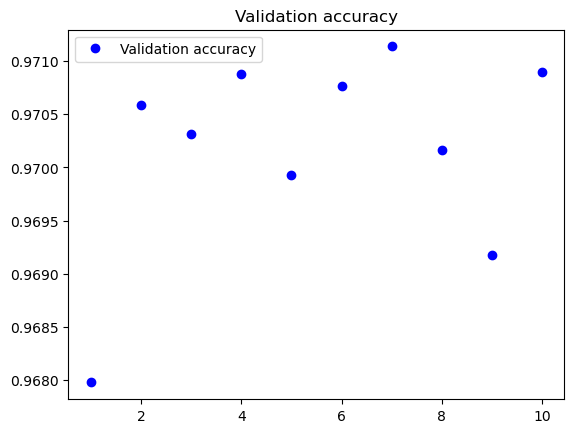

In [45]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc_val_history) + 1)
plt.plot(epochs, acc_val_history, 'bo', label='Validation accuracy')
plt.title('Validation accuracy')
plt.legend()
plt.show()

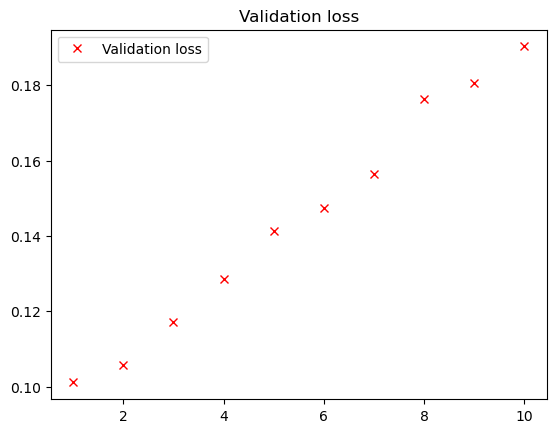

In [46]:
epochs = range(1, len(loss_val_history) + 1)
plt.plot(epochs, loss_val_history, 'rx', label='Validation loss')
plt.title('Validation loss')
plt.legend()
plt.show()

## Evaluation

### Validation set

In [47]:
model.eval()
X_val_bags_idx, X_val_bags_offsets, X_val_bags_freqs = batch_generator(X_val_idx, X_val_freqs)
y_val_pred = torch.argmax(model(X_val_bags_idx, X_val_bags_offsets, X_val_bags_freqs), dim=-1)

In [48]:
y_val_pred[:10]

tensor([15, 36, 19, 18, 28, 19, 11, 14, 32,  3])

In [49]:
print(classification_report(y_val, y_val_pred, target_names=langs, digits=4))

              precision    recall  f1-score   support

         ara     0.9946    0.9946    0.9946      1479
         ber     0.8044    0.7959    0.8001      1529
         bul     0.9452    0.9299    0.9375      1484
         ces     0.9860    0.9880    0.9870      1497
         cmn     0.9959    0.9966    0.9963      1475
         dan     0.9760    0.9701    0.9730      1507
         deu     0.9886    0.9892    0.9889      1484
         ell     1.0000    1.0000    1.0000      1511
         eng     0.9870    0.9775    0.9823      1557
         epo     0.9880    0.9862    0.9871      1590
         fin     0.9855    0.9869    0.9862      1446
         fra     0.9881    0.9836    0.9859      1525
         hau     0.9879    0.9932    0.9906      1479
         heb     1.0000    0.9993    0.9997      1480
         hun     0.9916    0.9846    0.9881      1562
         ina     0.9582    0.9595    0.9589      1458
         ita     0.9686    0.9726    0.9706      1461
         jpn     0.9987    

In [50]:
print(confusion_matrix(y_val, y_val_pred))

[[1471    0    0 ...    0    0    0]
 [   0 1217    0 ...    0    0    2]
 [   0    0 1380 ...    1    6    0]
 ...
 [   0    0    0 ... 1460    0    0]
 [   0    0    4 ...    0 1476    1]
 [   0    0    1 ...    0    0 1483]]


## Applying the Detector

In [51]:
def encode(text: str, MAXES):
    hashvals = ngrams2hashvals(all_ngrams(text), MAXES)
    hash2freqs_l = list(map(rel_freqs, hashvals))
    bags = ngrams_bags(hash2freqs_l)
    return batch_generator([bags[0]], [bags[1]])

In [52]:
test_sents = ['Groovin\' on a Sunday afternoon',
'La Folle Complainte', 
'Vent\'anni o poco più', 
'Tous les garçons et les filles',
'Mambo italiano']

In [53]:
for sent in test_sents:
    bags = encode(sent, MAXES)
    print(sent, '->', idx2lang[torch.argmax(model(bags[0], bags[1], bags[2]), dim=-1).item()])

Groovin' on a Sunday afternoon -> eng
La Folle Complainte -> fra
Vent'anni o poco più -> ita
Tous les garçons et les filles -> fra
Mambo italiano -> swc
